## Setup: imports and environment checks

In [6]:
import sys, gc
from pathlib import Path
import json

# Add project root to path (same pattern as notebooks/01_data_factory.ipynb)
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.insert(0, str(project_root))

import torch

def print_vram():
    """Print current GPU VRAM usage."""
    if torch.cuda.is_available():
        alloc = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        props = torch.cuda.get_device_properties(0)
        total = getattr(props, "total_memory", getattr(props, "total_mem", 0)) / 1024**3
        print(f"VRAM: {alloc:.1f}GB allocated / {reserved:.1f}GB reserved / {total:.1f}GB total")

def clear_vram():
    """Free unused VRAM."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"✓ Project root: {project_root}")
print(f"✓ torch: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print_vram()

# QLoRA needs bitsandbytes (usually Linux/Colab)
try:
    import bitsandbytes as bnb  # noqa: F401
    print("✓ bitsandbytes import: OK")
except Exception as e:
    print("✗ bitsandbytes import failed. If you are on Windows, run this notebook in Colab or WSL.")
    print("  Error:", repr(e))


✓ Project root: /content/operation-ledger-mind
✓ torch: 2.9.0+cu126
✓ CUDA available: True
✓ GPU: Tesla T4
VRAM: 0.0GB allocated / 0.0GB reserved / 14.7GB total
✓ bitsandbytes import: OK


## Hugging Face Login

In [7]:
from huggingface_hub import login

# Option 1: Login via Colab secrets (recommended)
try:
    from google.colab import userdata
    hf_token = userdata.get("HF_TOKEN")
    login(token=hf_token)
    print("✓ Logged in to Hugging Face via Colab secret (HF_TOKEN)")
except Exception:
    # Option 2: Login via environment variable
    import os
    hf_token = os.environ.get("HF_TOKEN", "")
    if hf_token:
        login(token=hf_token)
        print("✓ Logged in to Hugging Face via HF_TOKEN env variable")
    else:
        # Option 3: Interactive login (will prompt for token)
        print("⚠ No HF_TOKEN found. Running interactive login...")
        print("  Get your token at: https://huggingface.co/settings/tokens")
        login()
        print("✓ Logged in to Hugging Face interactively")

✓ Logged in to Hugging Face via Colab secret (HF_TOKEN)


In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    token=True
)

print("✓ Tokenizer loaded successfully")


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

✓ Tokenizer loaded successfully


## Load config + paths

In [9]:
from src.utils.config_loader import load_config
from src.finetuning.data import resolve_finetune_paths

config_path = project_root / "config" / "config.yaml"
config = load_config(config_path)
paths = resolve_finetune_paths(config)

print("✓ Base model:", config["finetuning"]["base_model"])
print("✓ Train file:", paths.train_file)
print("✓ Eval file:", paths.eval_file)
print("✓ Output dir:", paths.output_dir)

print("✓ Files exist:")
print("  - train:", paths.train_file.exists())
print("  - eval:", paths.eval_file.exists() if paths.eval_file else None)


✓ Base model: meta-llama/Meta-Llama-3-8B-Instruct
✓ Train file: data/output/train.jsonl
✓ Eval file: data/output/golden_test_set.jsonl
✓ Output dir: models/intern_adapter
✓ Files exist:
  - train: True
  - eval: True


## Setup: BitsAndBytesConfig + LoraConfig (QLoRA)

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTConfig, SFTTrainer

from src.finetuning.data import load_sft_datasets

ft_cfg = config["finetuning"]
tr_cfg = ft_cfg["training"]

base_model = ft_cfg["base_model"]
compute_dtype_str = ft_cfg.get("quantization", {}).get("compute_dtype", "float16")
compute_dtype = torch.float16 if str(compute_dtype_str).lower() in {"float16", "fp16"} else torch.bfloat16

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type=ft_cfg.get("quantization", {}).get("quant_type", "nf4"),
    bnb_4bit_use_double_quant=bool(ft_cfg.get("quantization", {}).get("double_quant", True)),
    bnb_4bit_compute_dtype=compute_dtype,
)

lora_config = LoraConfig(
    r=int(ft_cfg.get("lora", {}).get("r", 16)),
    lora_alpha=int(ft_cfg.get("lora", {}).get("alpha", 32)),
    lora_dropout=float(ft_cfg.get("lora", {}).get("dropout", 0.05)),
    target_modules=list(ft_cfg.get("lora", {}).get("target_modules", ["q_proj", "k_proj", "v_proj", "o_proj"])),
    bias=str(ft_cfg.get("lora", {}).get("bias", "none")),
    task_type=str(ft_cfg.get("lora", {}).get("task_type", "CAUSAL_LM")),
)

print("✓ BitsAndBytesConfig:", bnb_config)
print("✓ LoraConfig target_modules:", lora_config.target_modules)

# Tokenizer
trust_remote_code = bool(config.get("providers", {}).get("huggingface", {}).get("trust_remote_code", True))
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True, trust_remote_code=trust_remote_code)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Dataset → SFT-ready `text`
max_seq_length = int(tr_cfg.get("max_seq_length", 2048))
ds = load_sft_datasets(
    train_file=paths.train_file,
    eval_file=paths.eval_file,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
)

# Free any stale VRAM before loading the model
clear_vram()

# Model (4-bit) + LoRA
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map=config.get("providers", {}).get("huggingface", {}).get("device_map", "auto"),
    trust_remote_code=trust_remote_code,
    torch_dtype=compute_dtype,
    low_cpu_mem_usage=True,
)
model.config.use_cache = False

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

trainable, total = 0, 0
for p in model.parameters():
    total += p.numel()
    if p.requires_grad:
        trainable += p.numel()

print("✓ Model prepared for QLoRA")
print(f"  Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")
print_vram()

✓ BitsAndBytesConfig: BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "nf4",
  "bnb_4bit_use_double_quant": true,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

✓ LoraConfig target_modules: {'q_proj', 'k_proj', 'v_proj', 'o_proj'}


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/4032 [00:00<?, ? examples/s]

Map:   0%|          | 0/1008 [00:00<?, ? examples/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

✓ Model prepared for QLoRA
  Trainable params: 6,815,744 / 4,547,416,064 (0.15%)
VRAM: 7.3GB allocated / 9.6GB reserved / 14.7GB total


## Training: SFTTrainer loop (≥ 100 steps)

In [13]:
# For speed while testing, you can uncomment the next two lines.
# ds["train"] = ds["train"].select(range(min(256, len(ds["train"]))))
# if "eval" in ds: ds["eval"] = ds["eval"].select(range(min(64, len(ds["eval"]))))

out_dir = Path(paths.output_dir)
out_dir.mkdir(parents=True, exist_ok=True)

min_steps = int(tr_cfg.get("min_steps", 100))
max_steps = max(min_steps, int(tr_cfg.get("max_steps", min_steps)))

# Build SFTConfig — handle TRL version differences for max_seq_length / dataset_text_field
import inspect

sft_config_params = inspect.signature(SFTConfig).parameters
sft_trainer_params = inspect.signature(SFTTrainer).parameters

# Compute warmup_steps from warmup_ratio (warmup_ratio is deprecated in newer TRL)
warmup_ratio_val = float(tr_cfg.get("warmup_ratio", 0.03))
warmup_steps = max(1, int(warmup_ratio_val * max_steps))

sft_kwargs = dict(
    output_dir=str(out_dir),
    max_steps=max_steps,
    num_train_epochs=float(tr_cfg.get("num_epochs", 1)),
    per_device_train_batch_size=int(tr_cfg.get("batch_size", 1)),
    gradient_accumulation_steps=int(tr_cfg.get("gradient_accumulation_steps", 1)),
    learning_rate=float(tr_cfg.get("learning_rate", 2e-4)),
    warmup_steps=warmup_steps,
    logging_steps=int(tr_cfg.get("logging_steps", 10)),
    save_steps=int(tr_cfg.get("save_steps", 50)),
    packing=False,
    # Use bf16 — avoids the FP16 gradient scaler bug in PyTorch 2.9+
    # (scaler crashes on BFloat16 grads from quantized layers)
    fp16=False,
    bf16=True,
    gradient_checkpointing=True,
    optim=str(tr_cfg.get("optim", "paged_adamw_8bit")),
    report_to=[],
)

# max_seq_length: in SFTConfig for older TRL, in SFTTrainer for newer TRL
if "max_seq_length" in sft_config_params:
    sft_kwargs["max_seq_length"] = max_seq_length

# dataset_text_field: in SFTConfig for older TRL, in SFTTrainer for newer TRL
if "dataset_text_field" in sft_config_params:
    sft_kwargs["dataset_text_field"] = "text"

sft_args = SFTConfig(**sft_kwargs)

# Build SFTTrainer — pass max_seq_length / dataset_text_field here if the newer API expects it
trainer_kwargs = dict(
    model=model,
    args=sft_args,
    train_dataset=ds["train"],
    eval_dataset=ds.get("eval"),
    processing_class=tokenizer,
)

if "max_seq_length" in sft_trainer_params and "max_seq_length" not in sft_config_params:
    trainer_kwargs["max_seq_length"] = max_seq_length

if "dataset_text_field" in sft_trainer_params and "dataset_text_field" not in sft_config_params:
    trainer_kwargs["dataset_text_field"] = "text"

trainer = SFTTrainer(**trainer_kwargs)

print(f"✓ SFTTrainer ready — batch_size={sft_args.per_device_train_batch_size}, "
      f"grad_accum={sft_args.gradient_accumulation_steps}, "
      f"max_seq_length={max_seq_length}, "
      f"optim={sft_args.optim}")
print_vram()

train_result = trainer.train()
print("✓ Train result:", train_result)
print_vram()

# Save adapters + tokenizer
trainer.model.save_pretrained(str(out_dir))
tokenizer.save_pretrained(str(out_dir))

adapter_dir = out_dir
print("✓ Saved adapters to:", adapter_dir)
print("✓ Adapter files:")
for p in sorted(Path(adapter_dir).glob("*")):
    print(" -", p.name)


✓ SFTTrainer ready — batch_size=1, grad_accum=8, max_seq_length=1024, optim=OptimizerNames.PAGED_ADAMW_8BIT
VRAM: 7.3GB allocated / 9.5GB reserved / 14.7GB total


Step,Training Loss
10,2.931094
20,1.749570
30,1.478725
40,1.429366
50,1.435551
60,1.358614
70,1.337484
80,1.295952
90,1.312056
100,1.328070


✓ Train result: TrainOutput(global_step=100, training_loss=1.5656481456756592, metrics={'train_runtime': 839.1379, 'train_samples_per_second': 0.953, 'train_steps_per_second': 0.119, 'total_flos': 8430967114186752.0, 'train_loss': 1.5656481456756592})
VRAM: 7.3GB allocated / 9.5GB reserved / 14.7GB total
✓ Saved adapters to: models/intern_adapter
✓ Adapter files:
 - README.md
 - adapter_config.json
 - adapter_model.safetensors
 - chat_template.jinja
 - checkpoint-100
 - checkpoint-50
 - tokenizer.json
 - tokenizer_config.json


## Training: loss curve

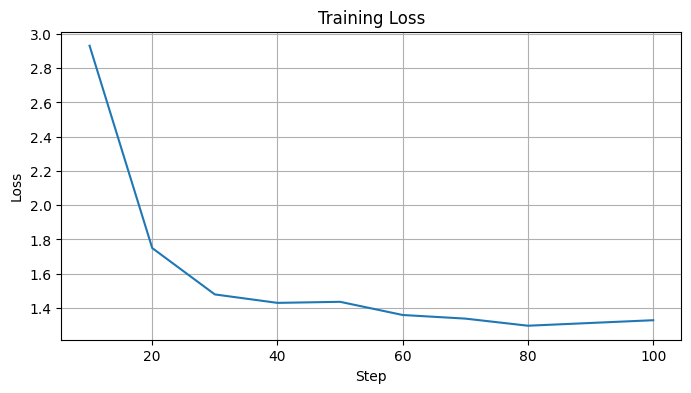

In [14]:
import matplotlib.pyplot as plt

log_history = getattr(trainer.state, "log_history", [])
steps = [x["step"] for x in log_history if "loss" in x and "step" in x]
losses = [x["loss"] for x in log_history if "loss" in x and "step" in x]

if not losses:
    print("No loss entries found in trainer.state.log_history (try lowering logging_steps).")
else:
    plt.figure(figsize=(8, 4))
    plt.plot(steps, losses)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


## Inference pipeline: query_intern(question)

In [15]:
import gc
del trainer, model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("✓ Training model freed from VRAM")
print_vram()

# --- Load inference pipeline ---
from src.finetuning.intern_inference import query_intern

# ──────────────────────────────────────────────────────────────
# Demo 1: Simple call — query_intern(question)
# This is the primary API. It loads base model + saved LoRA
# adapters automatically from config defaults.
# ──────────────────────────────────────────────────────────────
print("=" * 60)
print("Demo 1: query_intern(question)  [no context]")
print("=" * 60)
answer = query_intern("What is Uber's Adjusted EBITDA for 2024?")
print(f"\nQuestion: What is Uber's Adjusted EBITDA for 2024?")
print(f"Answer:   {answer}")

# ──────────────────────────────────────────────────────────────
# Demo 2: With context — query_intern(question, chunk_text=...)
# Pass a chunk as grounding context (used during RAG / eval).
# ──────────────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("Demo 2: query_intern(question, chunk_text=...)  [with context]")
print("=" * 60)

example = None
if paths.eval_file and paths.eval_file.exists():
    with open(paths.eval_file, "r", encoding="utf-8") as f:
        example = json.loads(next(iter(f)))

if example:
    q = example["question"]
    ctx = example.get("chunk_text")
    gt = example.get("answer")

    pred = query_intern(q, chunk_text=ctx, config_path=config_path)

    print(f"\nQuestion:     {q}")
    print(f"Ground truth: {gt}")
    print(f"Intern:       {pred}")
else:
    pred = query_intern("What is Adjusted EBITDA?", config_path=config_path)
    print(f"\nIntern: {pred}")

# ──────────────────────────────────────────────────────────────
# Demo 3: "Information not available" — question outside context
# ──────────────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("Demo 3: Out-of-scope question (should say info not available)")
print("=" * 60)
oos = query_intern(
    "What was Apple's revenue in 2024?",
    chunk_text="Uber's total revenue for 2024 was $43.9 billion.",
    config_path=config_path,
)
print(f"\nQuestion: What was Apple's revenue in 2024?")
print(f"Context:  Uber's total revenue for 2024 was $43.9 billion.")
print(f"Intern:   {oos}")

print("\n✓ Inference pipeline verified")
print_vram()


✓ Training model freed from VRAM
VRAM: 7.3GB allocated / 9.5GB reserved / 14.7GB total
Demo 1: query_intern(question)  [no context]


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]


Question: What is Uber's Adjusted EBITDA for 2024?
Answer:   The Adjusted EBITDA for 2024 is $1.4 billion.

Demo 2: query_intern(question, chunk_text=...)  [with context]

Question:     How long is each offering period in the Employee Stock Purchase Plan (ESPP)?
Ground truth: Each offering period in the ESPP is twelve months long.
Intern:       Each offering period is 12 months, with two purchase periods of approximately 6 months each.

Demo 3: Out-of-scope question (should say info not available)

Question: What was Apple's revenue in 2024?
Context:  Uber's total revenue for 2024 was $43.9 billion.
Intern:   Apple's revenue in 2024 was $394 billion.

✓ Inference pipeline verified
VRAM: 12.7GB allocated / 13.3GB reserved / 14.7GB total
